In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir

from numpy.linalg import svd, pinv
from scipy.linalg import eig

In [2]:
# %%
# Parameters
Lx, Lz = 20,1
Nx, Nz = 1280, 64
Ra_M = 1.0e7
D_0 = 0
D_H = 1/3
M_0 = 0
M_H = -1
N_s2=4/3
f=0.05

Prandtl = 1.0
dealias = 3/2
stop_sim_time = 2500
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

kappa = (Ra_M * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
print('kappa',kappa)
print('nu',nu)
Td=Lz**2/(nu*kappa)**(1/2)
Tc=(Lz/(M_0-M_H))**(1/2)
Tr=1/f
R_0=Tr/Tc
print('R_0',R_0)

kappa 0.00031622776601683794
nu 0.00031622776601683794
R_0 20.0


In [3]:
folder_dir = "analysis_2"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

['analysis_2/analysis_2_s1.h5', 'analysis_2/analysis_2_s2.h5', 'analysis_2/analysis_2_s3.h5']


In [4]:
np.concatenate((np.array([[1, 2, 3]]), np.array([[7, 8, 9]])))

array([[1, 2, 3],
       [7, 8, 9]])

In [5]:
def get_all_data(task, Nz):
    recorded = False
    for file in file_paths:
        with h5py.File(file, mode='r') as file:
            st = file['scales/sim_time']
            simtime = np.array(st)
            avg_0 = file["tasks"][task]
            avg = np.reshape(avg_0, (len(simtime),Nz))
            for t in range(len(simtime)):
                avg_T=np.transpose(avg[t,:])
                avg_T = np.reshape(avg_T, (1, Nz))
                if recorded == False:
                    avg_all_time = avg_T
                    recorded = True
                else:
                    avg_all_time = np.concatenate((avg_all_time, avg_T))
    print(np.shape(avg_all_time))
    print(np.shape(np.transpose(avg_all_time[:,:])))
    avg_allt_T=np.transpose(avg_all_time[:,:])
    return avg_allt_T
def draw_contour(avg_allt_T, task):
    plt.contourf(avg_allt_T, cmap='Spectral_r')
    plt.colorbar(label=f'{task}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'{task} vs time')
    #plt.savefig(f'{task.replace(" ", "_")}.png', dpi=200,bbox_inches='tight')
    plt.show()
    matplotlib.pyplot.close()

(2500, 64)
(64, 2500)


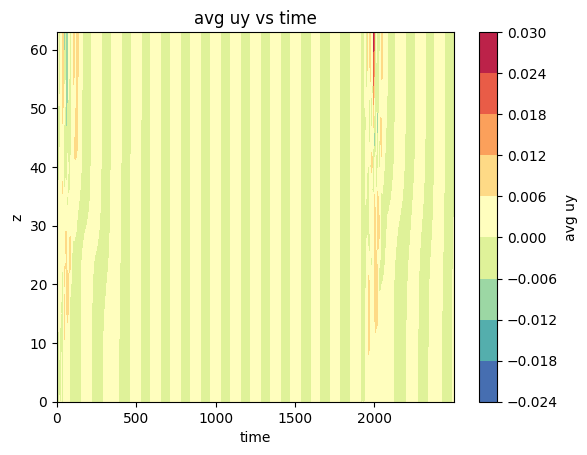

In [6]:
avg_uy_all_time = get_all_data("avg uy by x", Nz)

draw_contour(avg_uy_all_time, "avg uy")

In [7]:
def DMD2(mat_A, r=None):
    """
    Perform Dynamic Mode Decomposition (DMD) on the dataset KE_all_time.

    Parameters:
    - KE_all_time: NumPy array of shape (32, 2000), where each column is a data snapshot.
    - r: Number of singular values/modes to keep. If None, use full rank.

    Returns:
    - Phi: DMD modes
    - Lambda: Eigenvalues of the DMD modes
    - b: Amplitudes of the DMD modes
    """

    # Step 1: Prepare the data matrices X and X'
    X = mat_A[:, :-1]
    X_prime = mat_A[:, 1:]

    # Step 2: Perform SVD on X
    U, Sigma, Vh = svd(X, full_matrices=False) # it is in the reduced form
    if r is not None:
        U = U[:, :r]
        Sigma = Sigma[:r]
        Vh = Vh[:r, :]

    # Step 3: Compute the pseudo-inverse of Sigma for the best-fit linear operator
    Sigma_inv = np.diag(1.0 / Sigma)

    # Compute the approximate linear operator A_tilde
    A_tilde = U.T @ X_prime @ Vh.T @ Sigma_inv

    # Step 4: Compute eigenvalues and eigenvectors of A_tilde
    Lambda, W = eig(A_tilde)

    # Compute DMD modes
    Phi = U @ W

    # Compute DMD amplitudes
    b = pinv(Phi) @ mat_A[:, 0]

    return Phi, Lambda, b

In [8]:

def DMD(mat_A, r=None):
    """
    Perform Dynamic Mode Decomposition (DMD) on the dataset KE_all_time.

    Parameters:
    - KE_all_time: NumPy array of shape (32, 2000), where each column is a data snapshot.
    - r: Number of singular values/modes to keep. If None, use full rank.

    Returns:
    - Phi: DMD modes
    - Lambda: Eigenvalues of the DMD modes
    - b: Amplitudes of the DMD modes
    """

    # Step 1: Prepare the data matrices X and X'
    X = mat_A[:, :-1]
    X_prime = mat_A[:, 1:]

    # Step 2: Perform SVD on X
    U, Sigma, Vh = svd(X, full_matrices=False) # it is in the reduced form
    if r is not None:
        U = U[:, :r]
        Sigma = Sigma[:r]
        Vh = Vh[:r, :]

    # Step 3: Compute the pseudo-inverse of Sigma for the best-fit linear operator
    Sigma_inv = np.diag(1.0 / Sigma)

    # Compute the approximate linear operator A_tilde
    A_tilde = U.T @ X_prime @ Vh.T @ Sigma_inv

    # Step 4: Compute eigenvalues and eigenvectors of A_tilde
    Lambda, W = eig(A_tilde)

    # Compute DMD modes
    Phi = X_prime @ Vh.T @ Sigma_inv @ W

    # Compute DMD amplitudes
    b = pinv(Phi) @ mat_A[:, 0]

    return Phi, Lambda, b

# Assuming KE_all_time is your (32, 4000) data array
# KE_all_time = np.random.rand(32, 4000)  # Example initialization, replace with your data

# Perform DMD (specify 'r' as needed, e.g., r=10 for top 10 modes)
# Phi, Lambda, b = DMD(KE_all_time, r=10)

# Now, Phi contains the DMD modes, Lambda contains the eigenvalues, and b contains the mode amplitudes

def compute_future_states(PHI, LAMBDA, B, TIMESTEPS, DT):
    """
    Compute the approximate solution at future times using DMD.

    Parameters:
    - Phi: DMD modes.
    - Lambda: Eigenvalues of the DMD modes.
    - b: Amplitudes of the DMD modes.
    - timesteps: Number of future time steps to compute.
    - dt: Time step between measurements in the original data.

    Returns:
    - X_future: The approximate future states of the system.
    """
    omega = np.log(LAMBDA) / DT
    t = np.arange(TIMESTEPS) * DT
    X_future = np.zeros((PHI.shape[0], TIMESTEPS), dtype=np.complex_)

    for i in range(TIMESTEPS):
        X_future[:, i] = np.dot(PHI, B * np.exp(omega * t[i]))
    
    return X_future.real

# Assuming KE_all_time is your data and you've already computed Phi, Lambda, b
# For example purposes, let's set some parameters
# Number of future time steps to predict
# Time step between snapshots in your original data

# Compute future states
# X_future = compute_future_states(Phi, Lambda, b, timesteps, dt)

# Note: This code assumes a consistent time step 'dt' between your original data snapshots.
# 'X_future' will contain the real part of the future states of the system.
# Adjust 'timesteps' and 'dt' as needed for your specific application.


In [9]:
def local_look(begin_time, end_time, data_all, name):
    datasample = data_all[:, begin_time:end_time]
    phi, Lam, b = DMD(datasample)
    dt = 1
    timesteps = 500
    future_data = compute_future_states(phi, Lam, b, timesteps, 1)
    n_rows, n_columns = datasample.shape
    x_ax = np.linspace(begin_time, end_time, n_columns)
    y_ax = np.linspace(0, n_rows-1, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    plt.contourf(X_ax, Y_ax, datasample, cmap='Spectral_r')
    plt.colorbar(label=f'avg_{name}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'avg {name} by z vs time')
    # plt.savefig(f'.png', dpi=200,bbox_inches='tight')
    plt.subplot(1,2,2)
    plt.contourf(future_data, cmap='Spectral_r')
    plt.colorbar(label=f'avg_{name}')
    plt.xlabel('time')
    plt.ylabel('z')
    plt.title(f'avg {name} by z vs time')
    # plt.savefig(f'.png', dpi=200,bbox_inches='tight')
    plt.show()
    plt.clf()

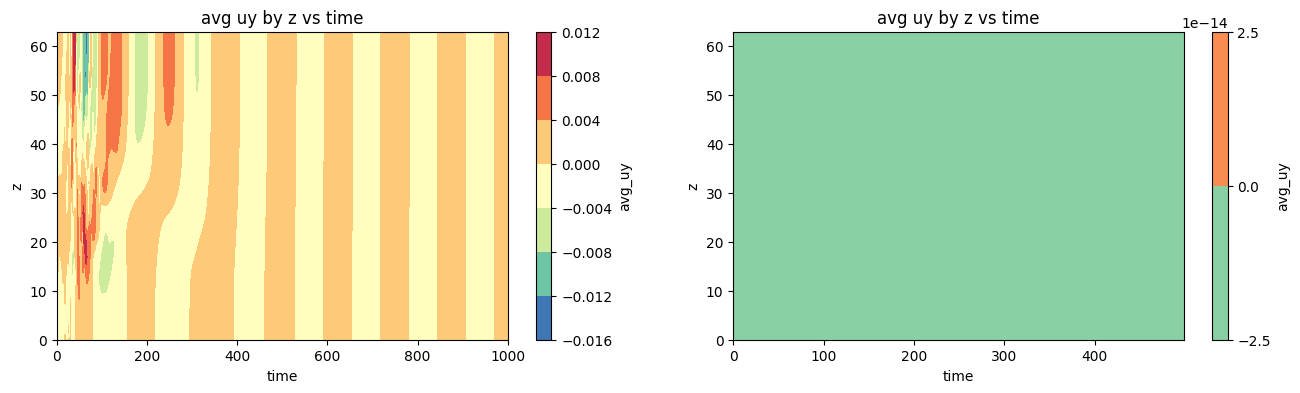

<Figure size 640x480 with 0 Axes>

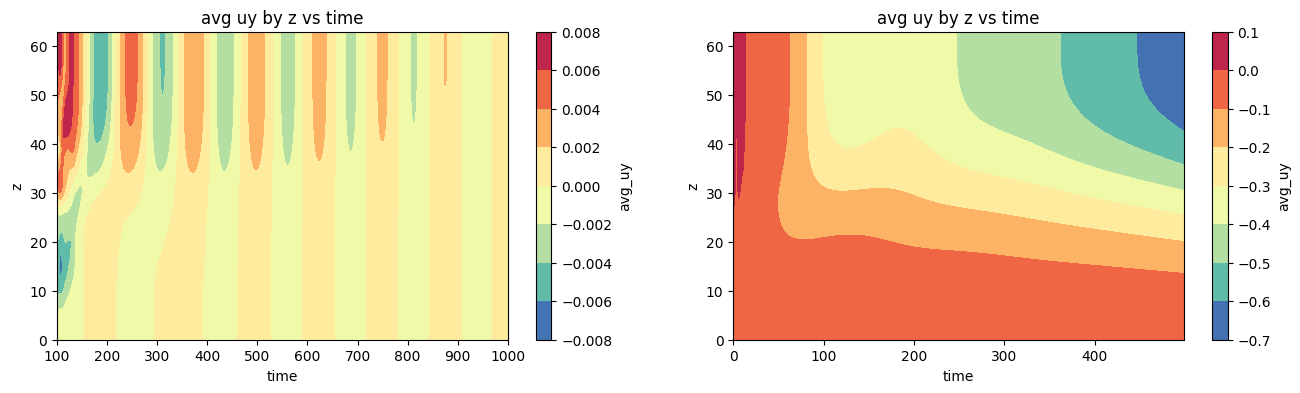

<Figure size 640x480 with 0 Axes>

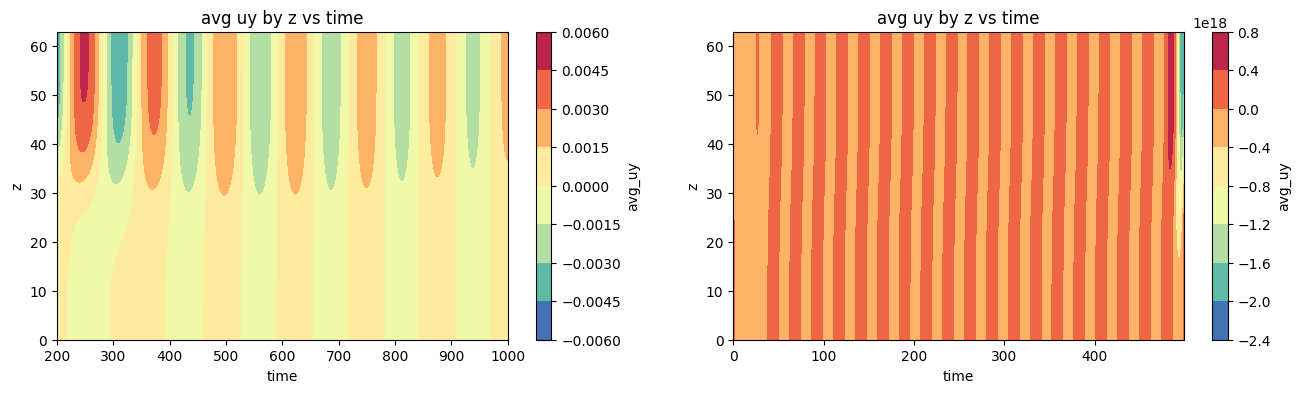

<Figure size 640x480 with 0 Axes>

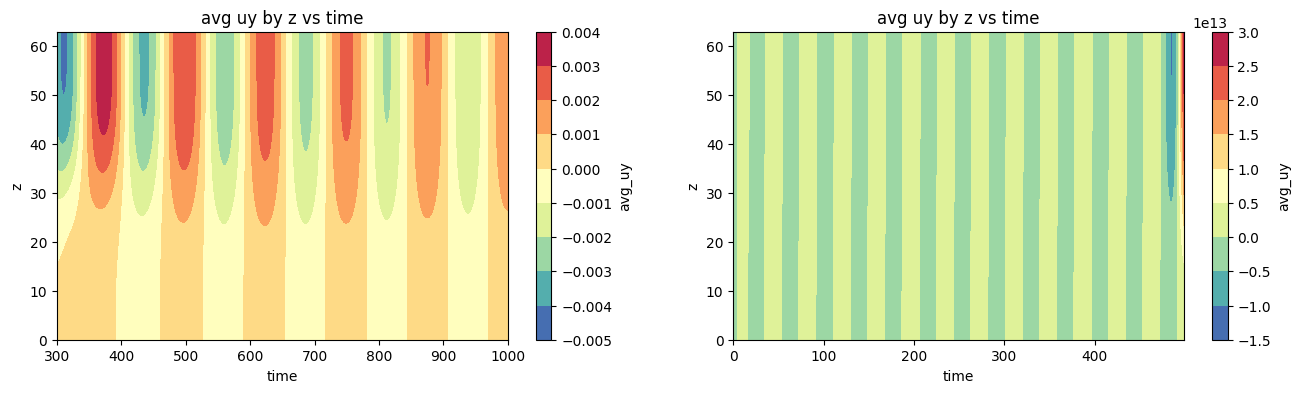

<Figure size 640x480 with 0 Axes>

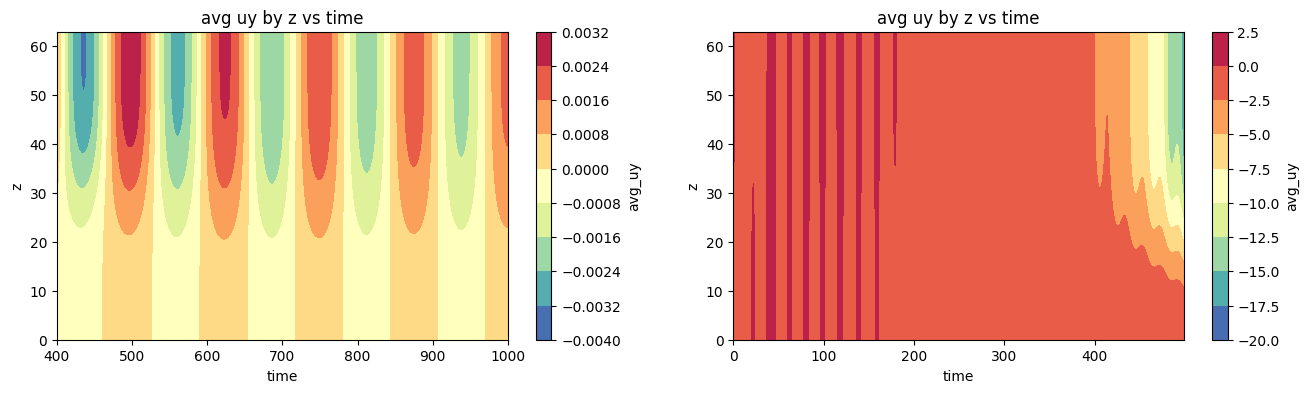

<Figure size 640x480 with 0 Axes>

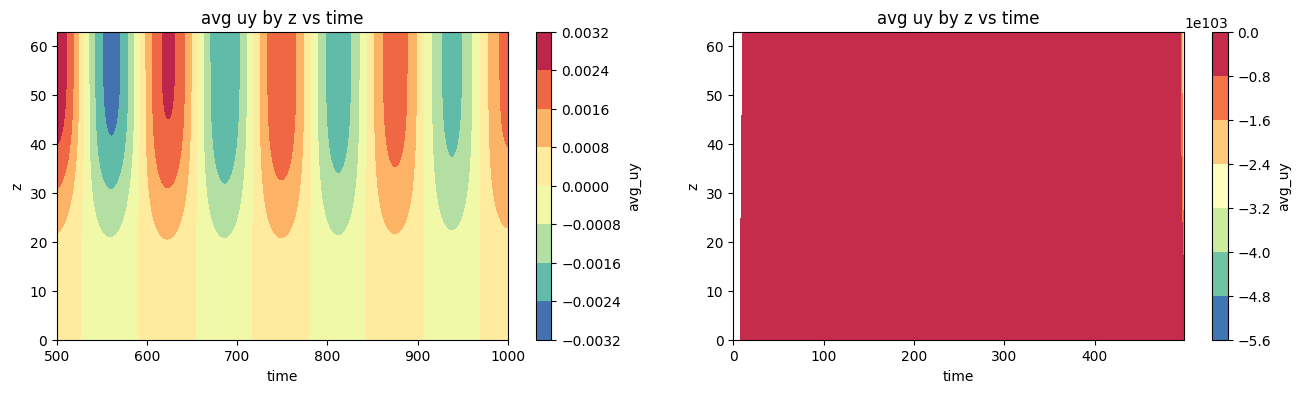

<Figure size 640x480 with 0 Axes>

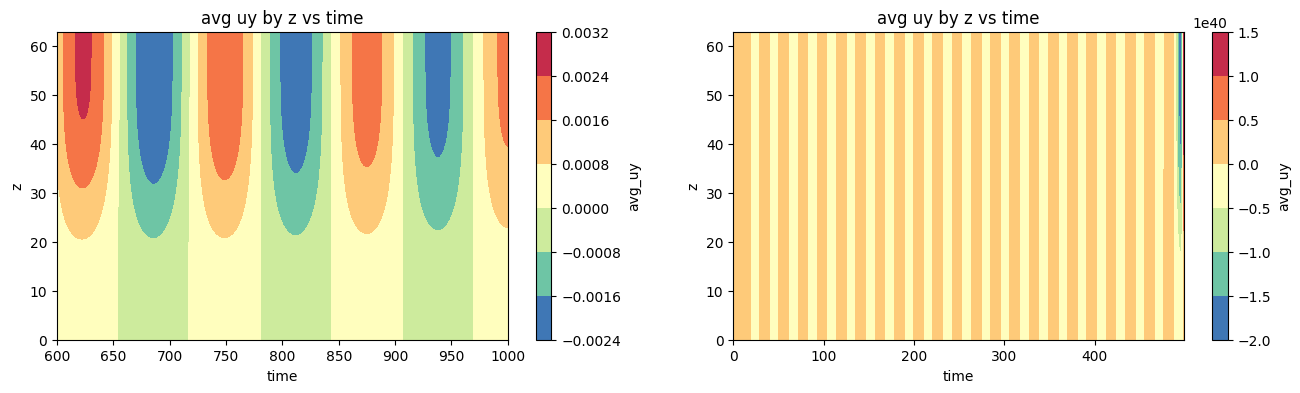

<Figure size 640x480 with 0 Axes>

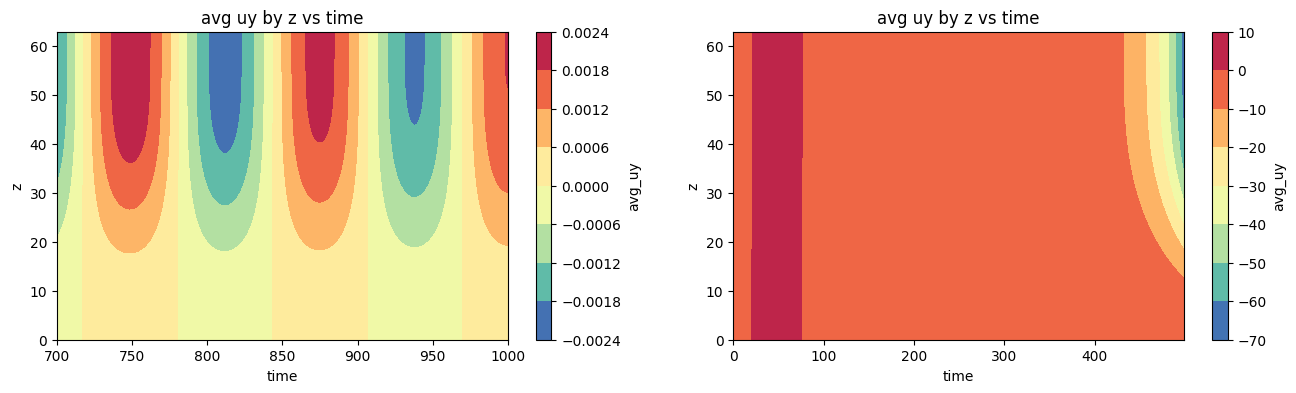

<Figure size 640x480 with 0 Axes>

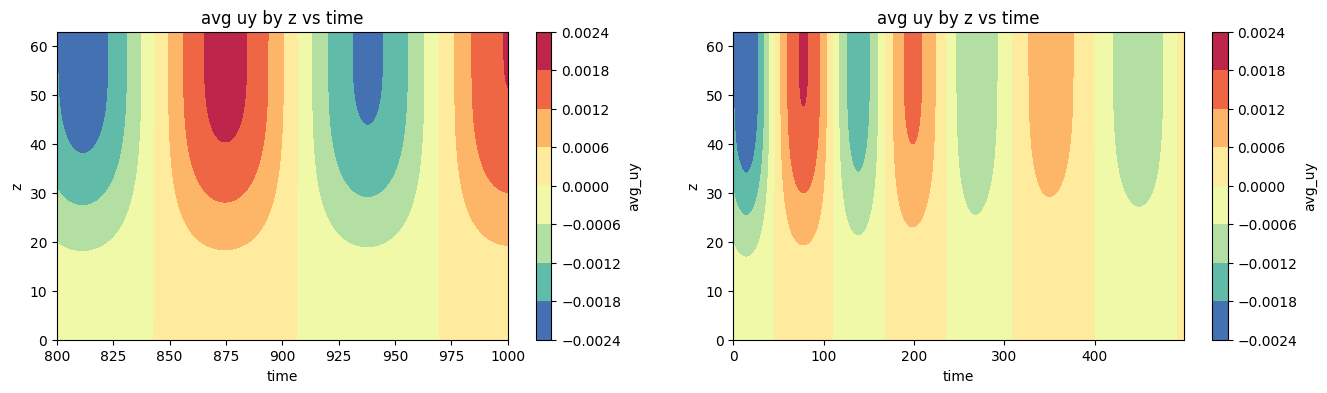

<Figure size 640x480 with 0 Axes>

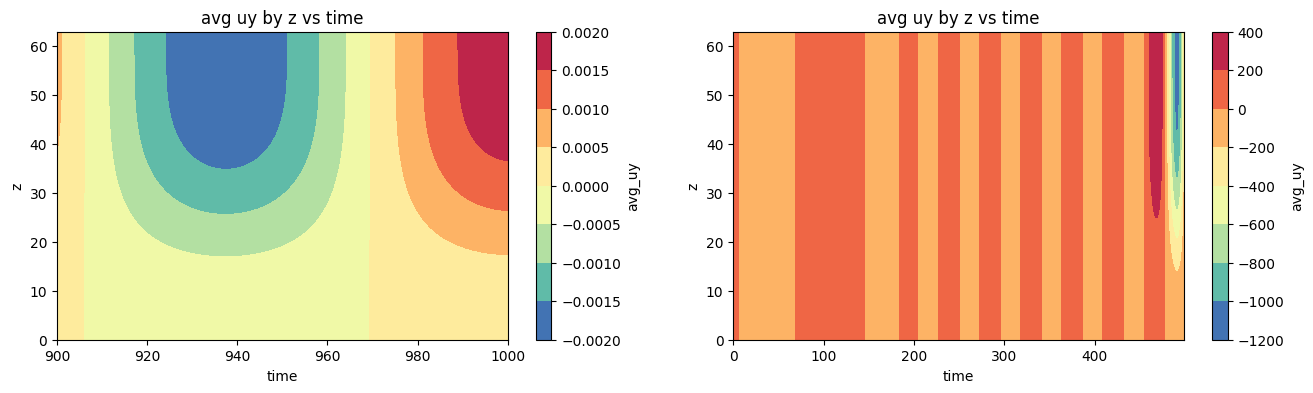

<Figure size 640x480 with 0 Axes>

In [10]:
for beginning_time in range(0, 1000, 100):
    local_look(beginning_time, 1000, avg_uy_all_time, 'uy')
# 800 is extremely good

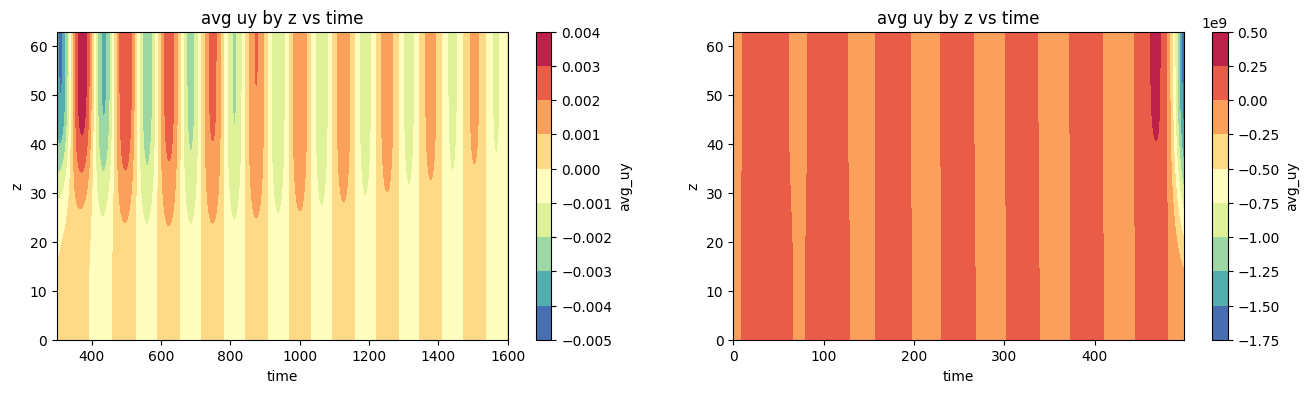

<Figure size 640x480 with 0 Axes>

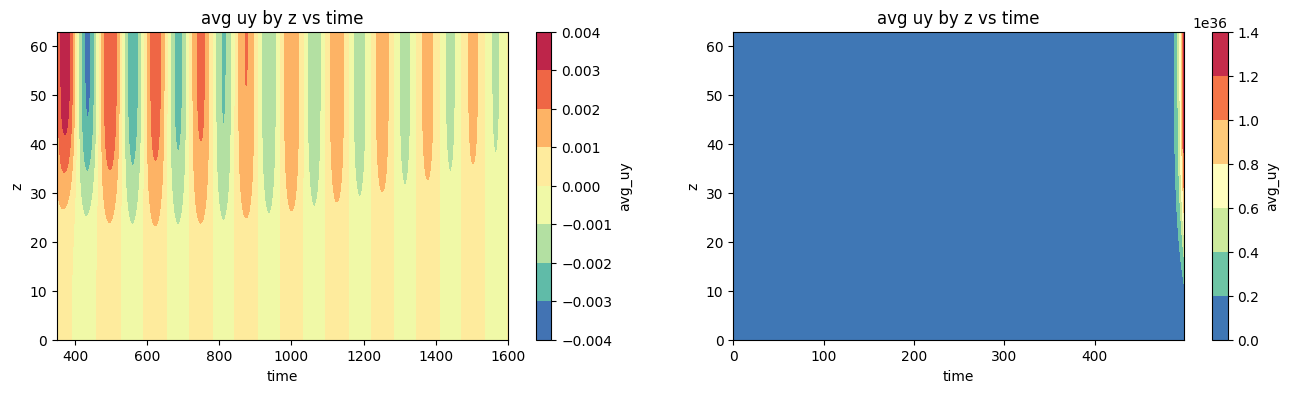

<Figure size 640x480 with 0 Axes>

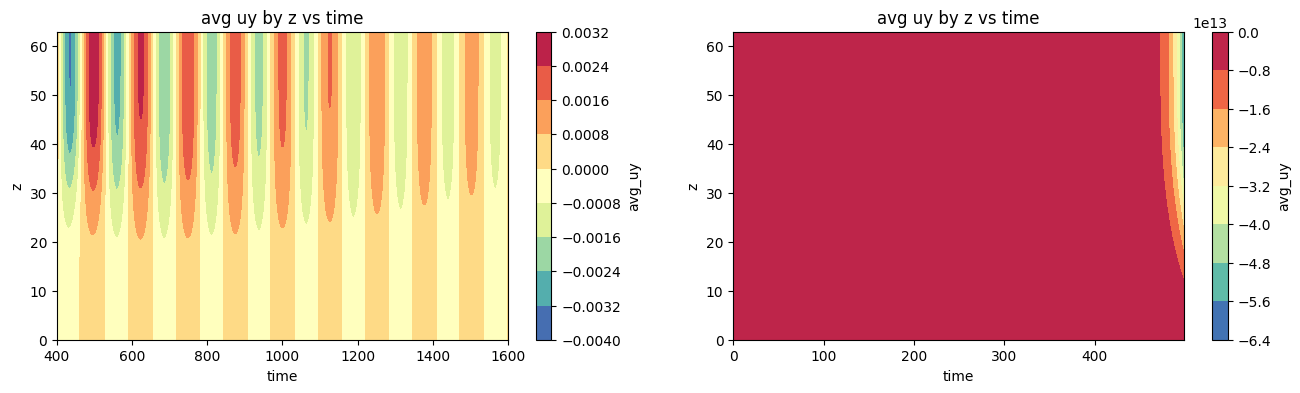

<Figure size 640x480 with 0 Axes>

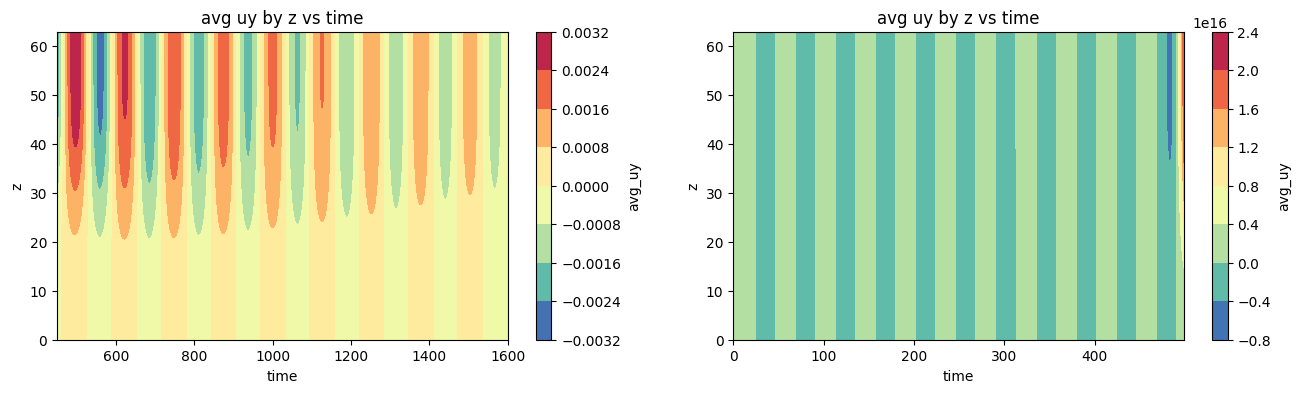

<Figure size 640x480 with 0 Axes>

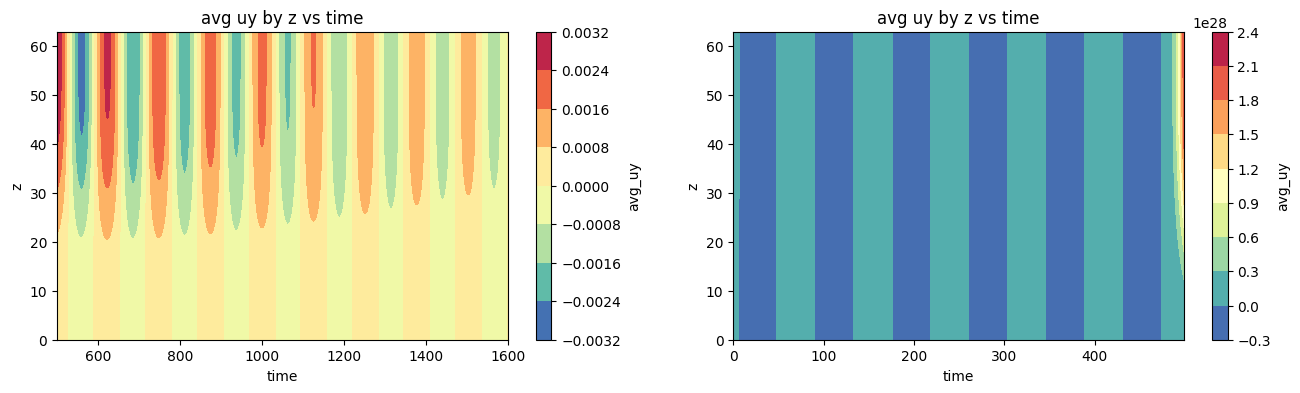

<Figure size 640x480 with 0 Axes>

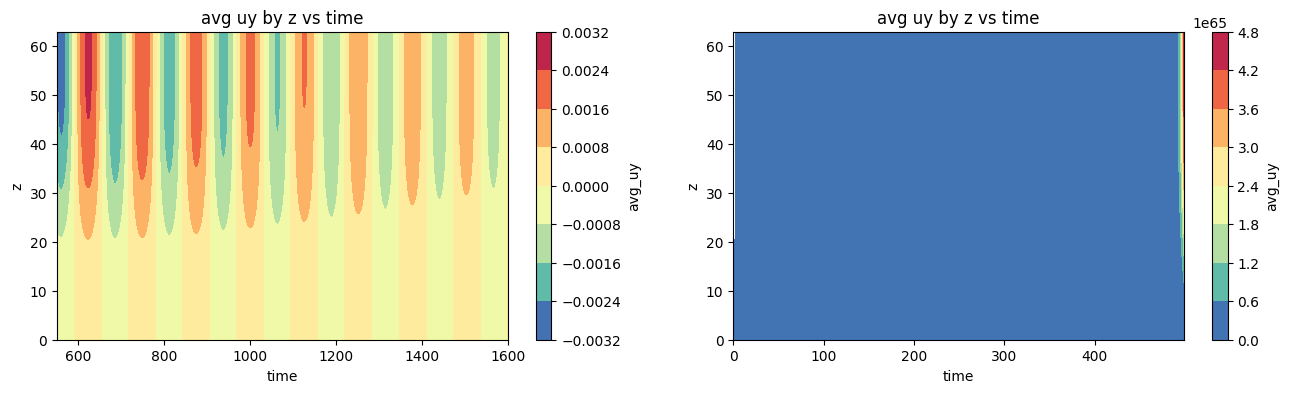

<Figure size 640x480 with 0 Axes>

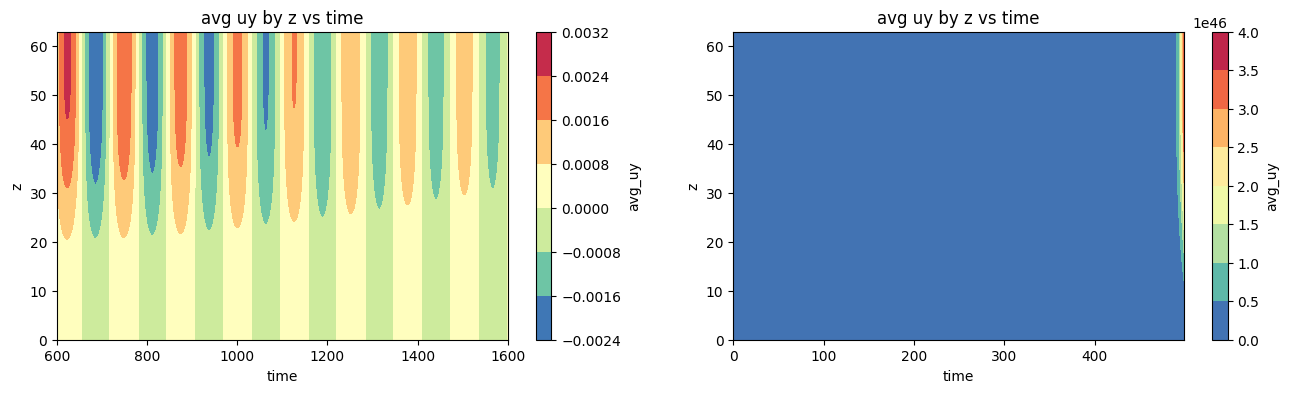

<Figure size 640x480 with 0 Axes>

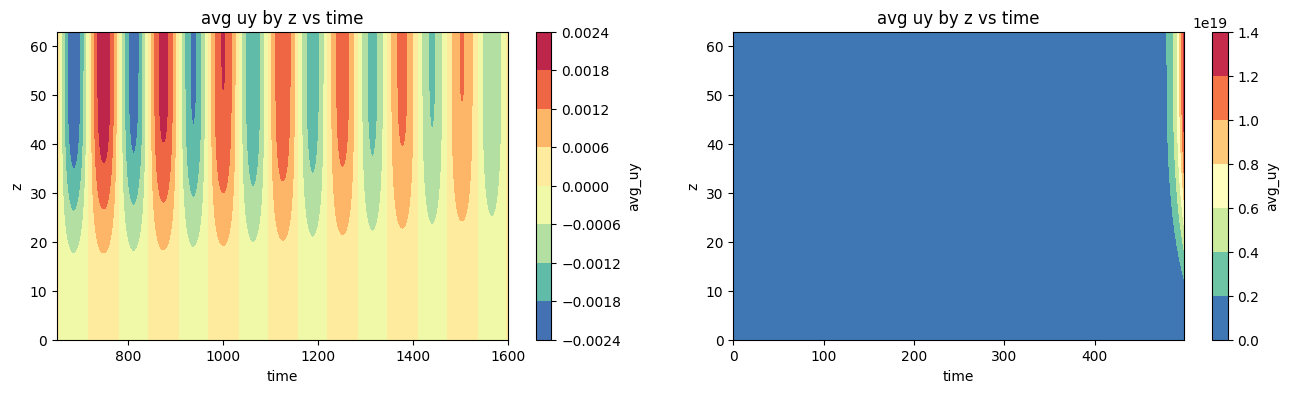

<Figure size 640x480 with 0 Axes>

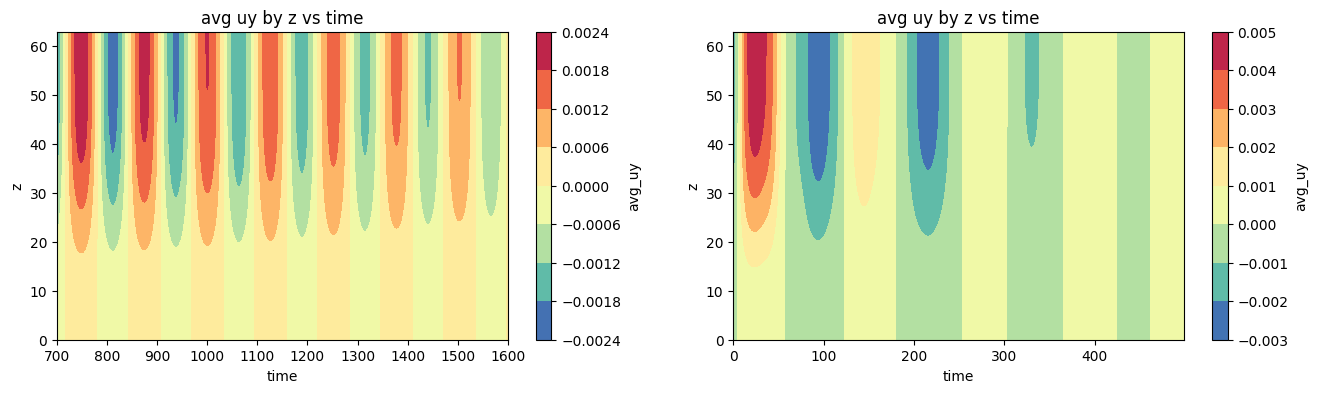

<Figure size 640x480 with 0 Axes>

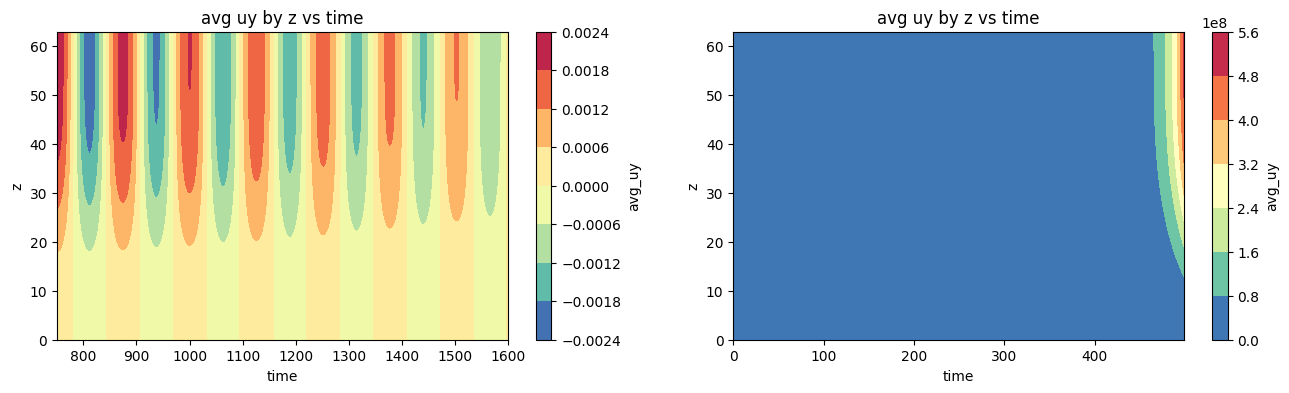

<Figure size 640x480 with 0 Axes>

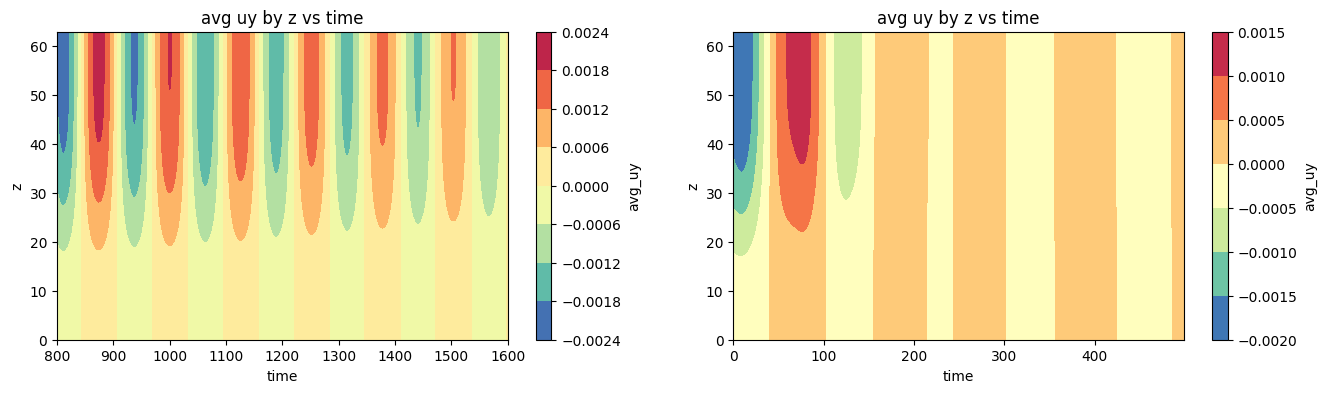

<Figure size 640x480 with 0 Axes>

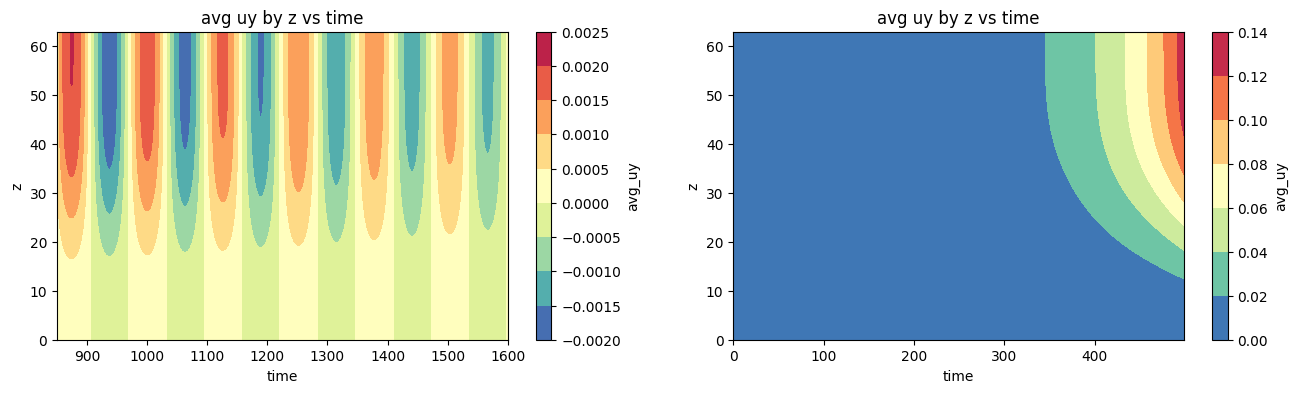

<Figure size 640x480 with 0 Axes>

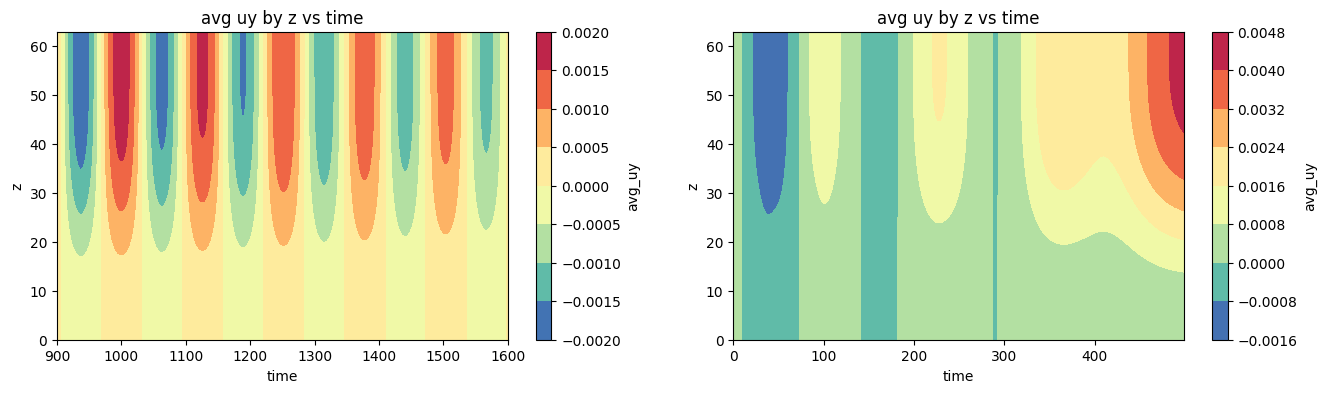

<Figure size 640x480 with 0 Axes>

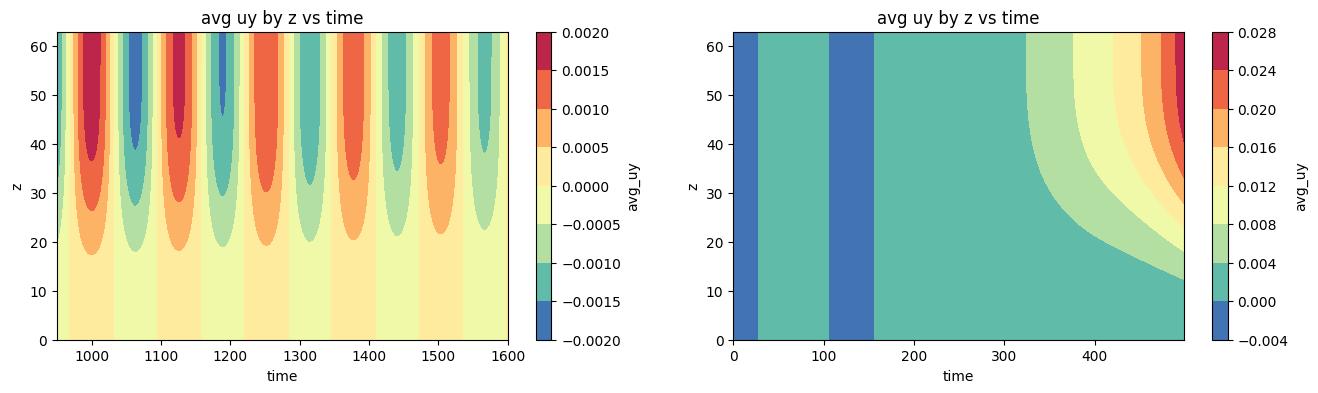

<Figure size 640x480 with 0 Axes>

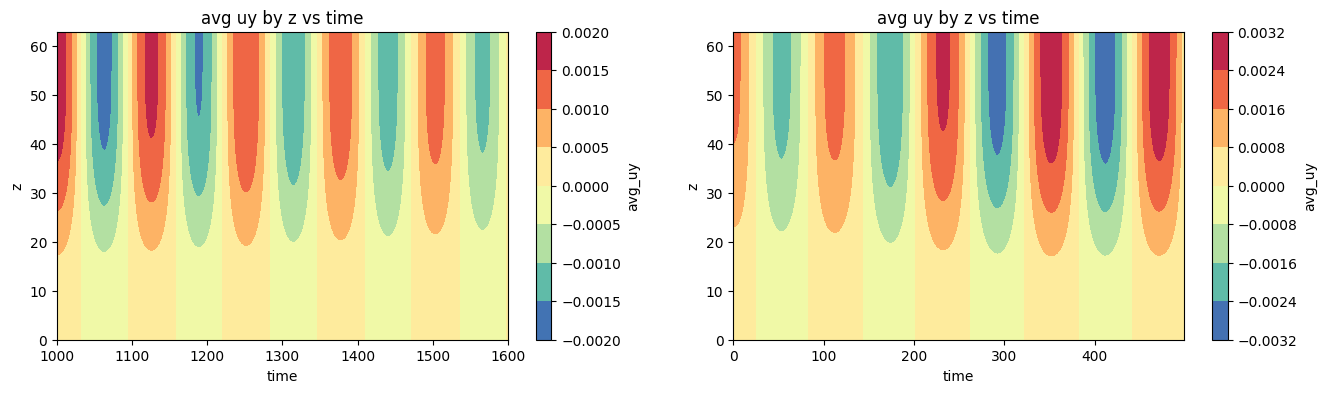

<Figure size 640x480 with 0 Axes>

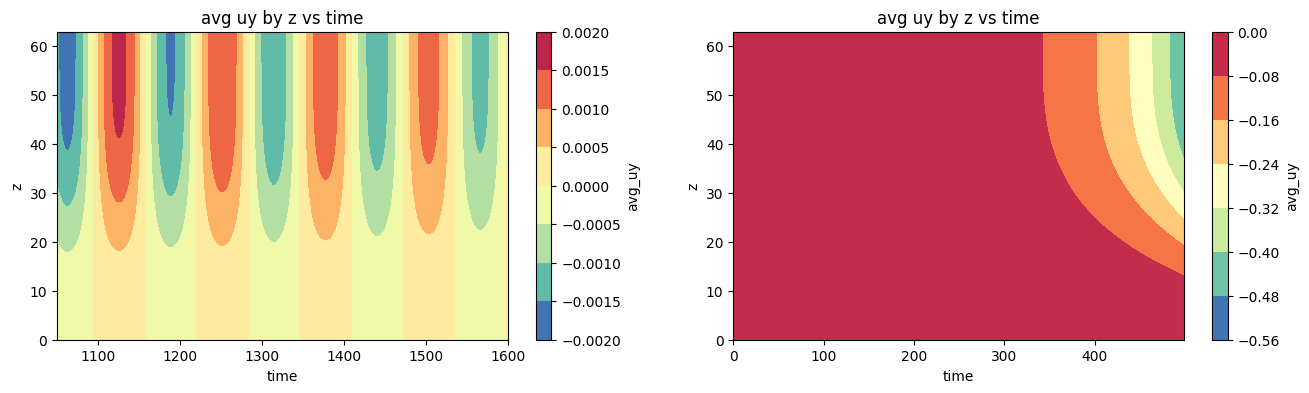

<Figure size 640x480 with 0 Axes>

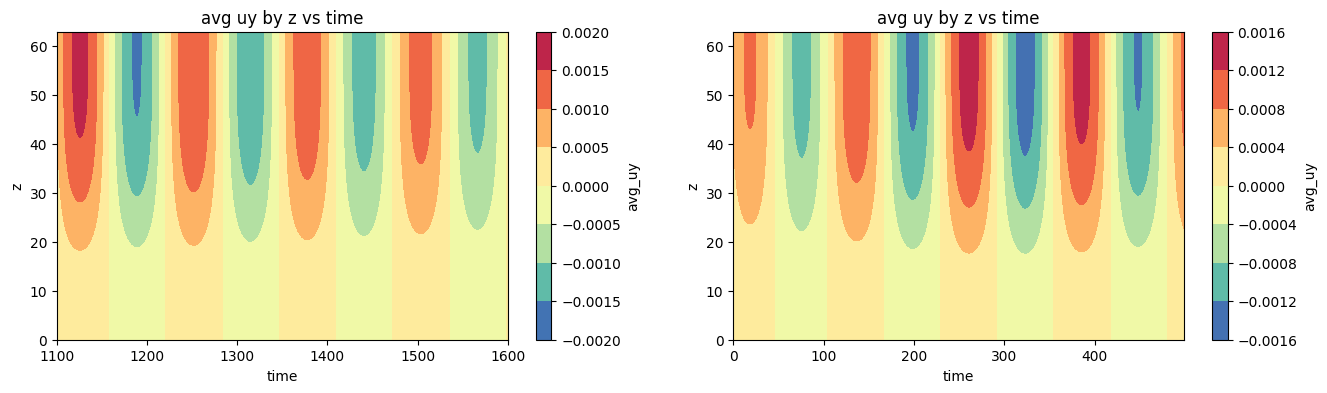

<Figure size 640x480 with 0 Axes>

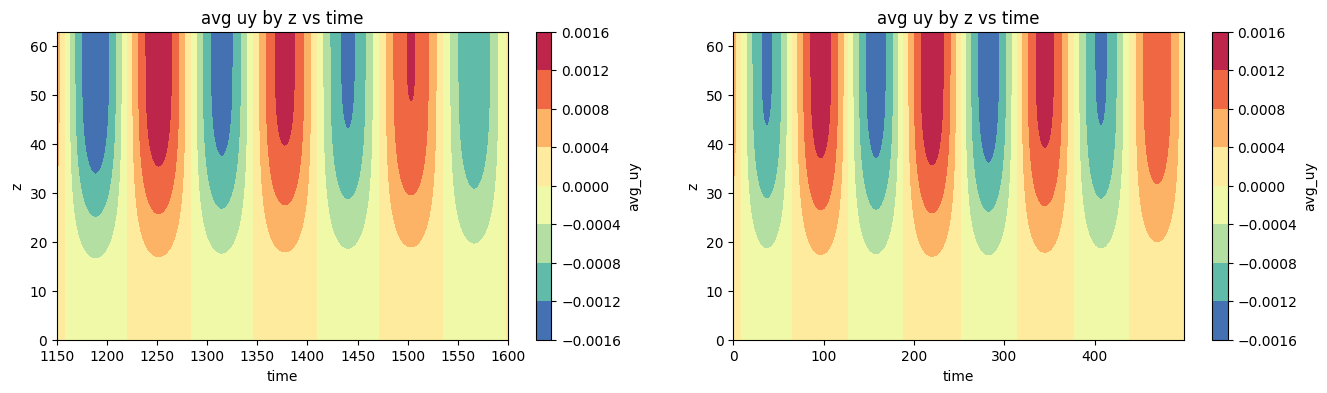

<Figure size 640x480 with 0 Axes>

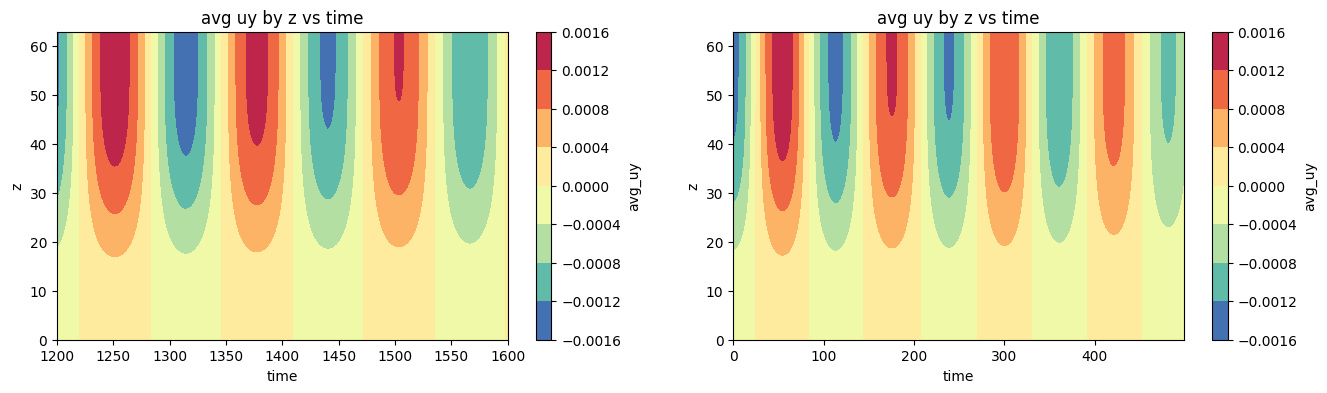

<Figure size 640x480 with 0 Axes>

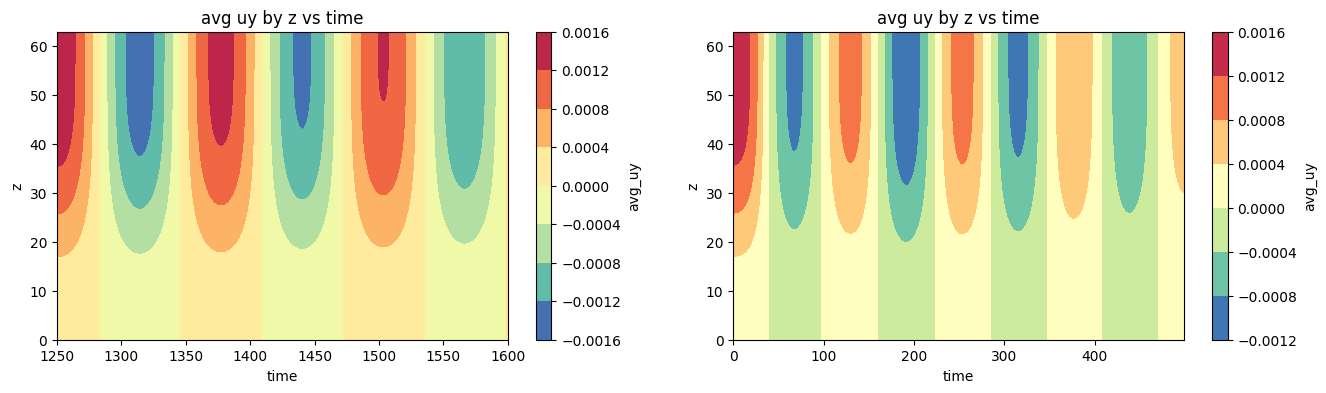

<Figure size 640x480 with 0 Axes>

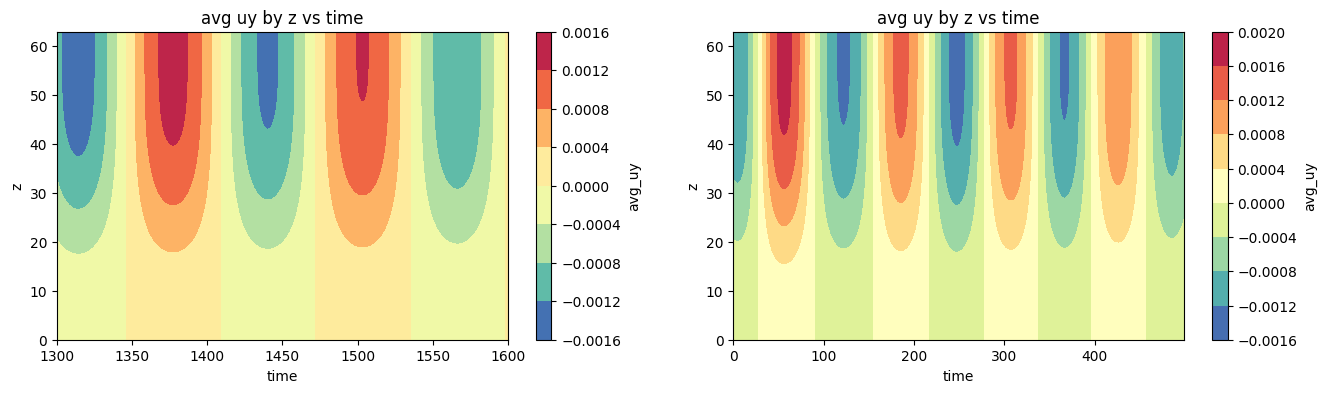

<Figure size 640x480 with 0 Axes>

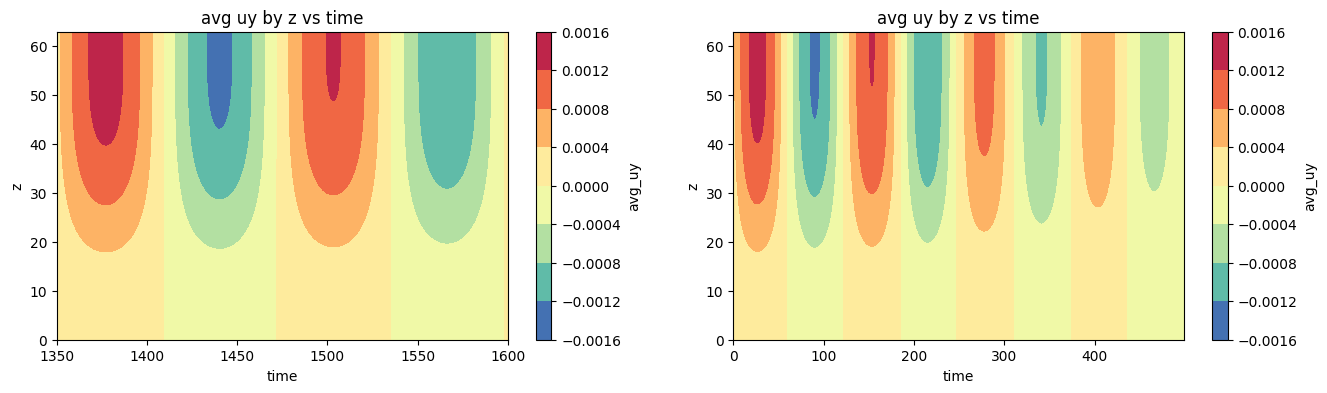

<Figure size 640x480 with 0 Axes>

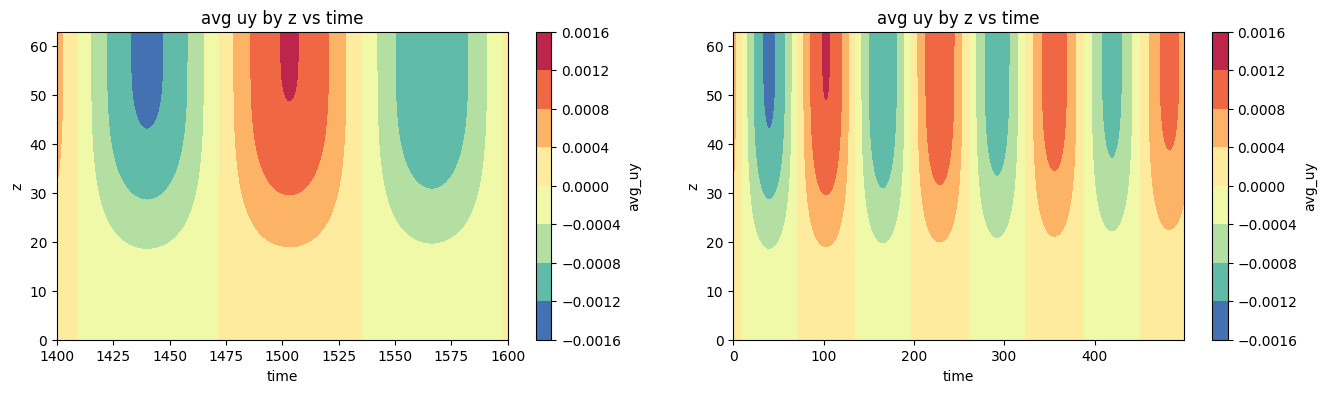

<Figure size 640x480 with 0 Axes>

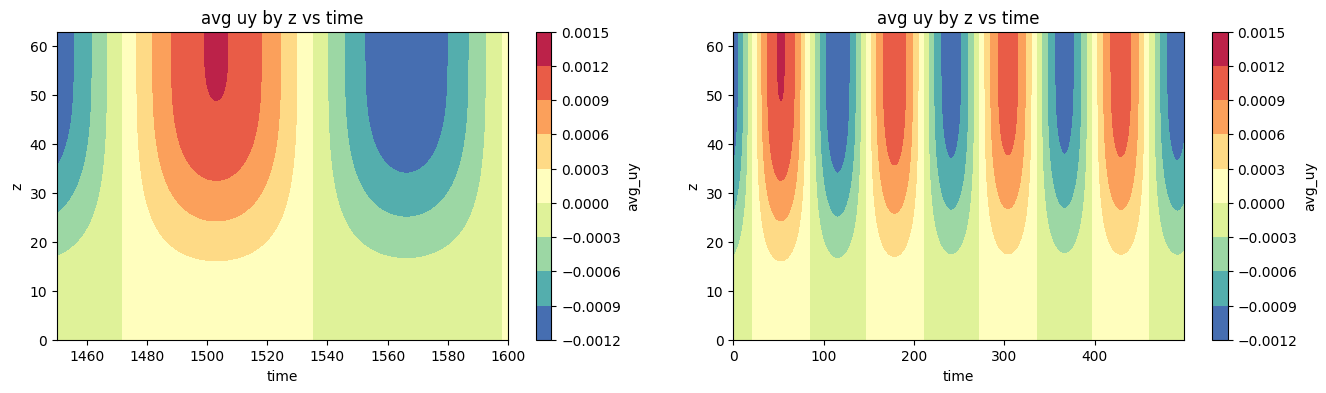

<Figure size 640x480 with 0 Axes>

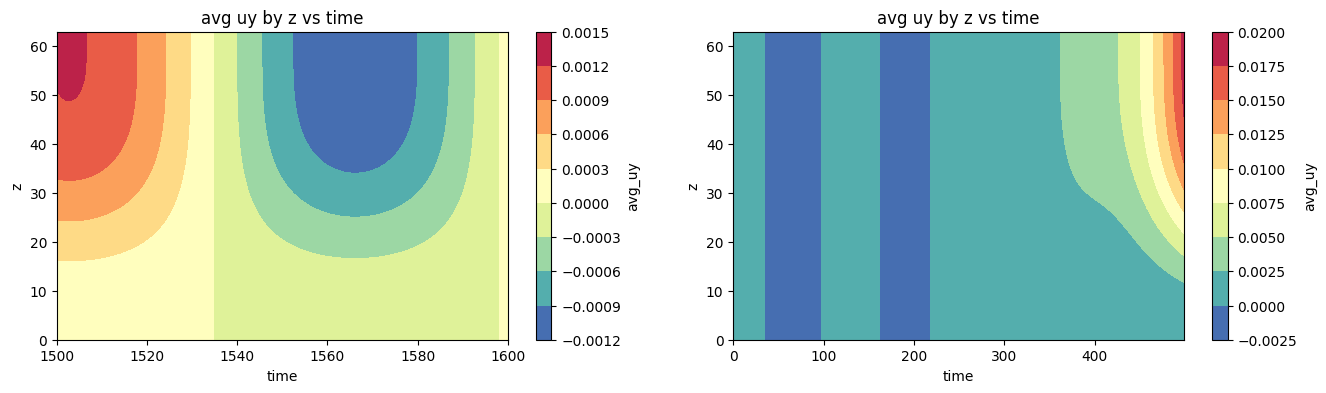

<Figure size 640x480 with 0 Axes>

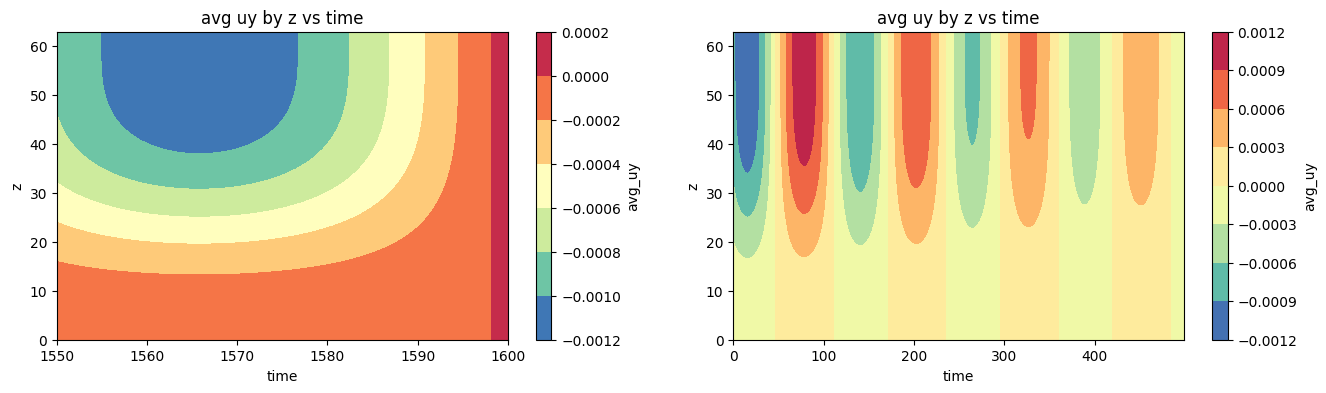

<Figure size 640x480 with 0 Axes>

In [11]:
for beginning_time in range(300, 1600, 50):
    local_look(beginning_time, 1600, avg_uy_all_time, 'uy')
# 1000, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450 are extremely good

In [12]:
#for beginning_time in range(600, 3000, 100):
#    local_look(beginning_time, 3500, avg_M_all_time, 'M')

(64, 2500)
[ 0.92902143+0.35508793j  0.92902143-0.35508793j  0.71167606+0.24681847j
  0.71167606-0.24681847j  0.94252691+0.30219155j  0.94252691-0.30219155j
  0.9456331 +0.24649672j  0.9456331 -0.24649672j  0.9732535 +0.17539629j
  0.9732535 -0.17539629j  0.83226666+0.j          0.98511553+0.11483359j
  0.98511553-0.11483359j  0.97775612+0.11105459j  0.97775612-0.11105459j
  0.97762307+0.06381579j  0.97762307-0.06381579j  0.99088188+0.04927771j
  0.99088188-0.04927771j  1.00319609+0.03616916j  1.00319609-0.03616916j
  0.99925502+0.j          0.04897693+0.19171934j  0.04897693-0.19171934j
 -0.16302997+0.10277741j -0.16302997-0.10277741j  0.14362806+0.j
 -0.05006887+0.11982076j -0.05006887-0.11982076j  0.05024984+0.07553074j
  0.05024984-0.07553074j -0.01708792+0.09552728j -0.01708792-0.09552728j
  0.00621789+0.09300715j  0.00621789-0.09300715j -0.08782972+0.05334847j
 -0.08782972-0.05334847j -0.10141007+0.j          0.06156035+0.04884768j
  0.06156035-0.04884768j -0.05579921+0.04547888j

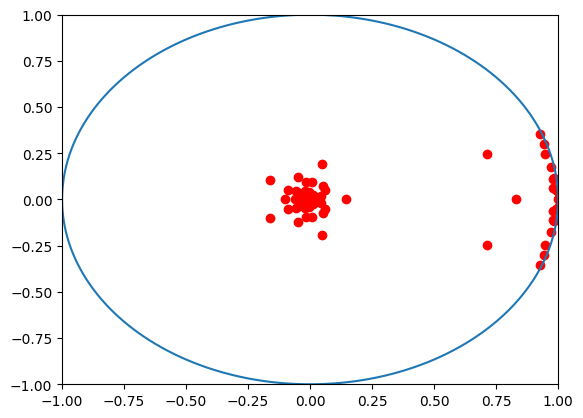

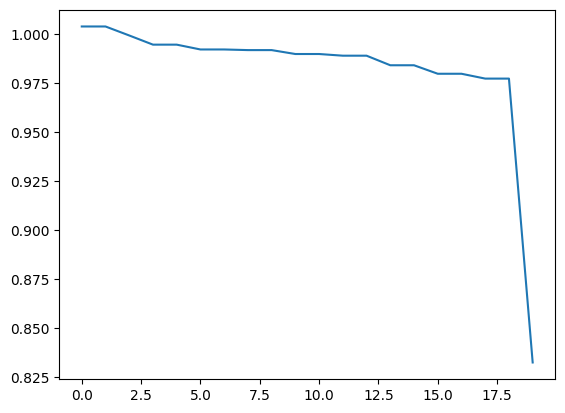

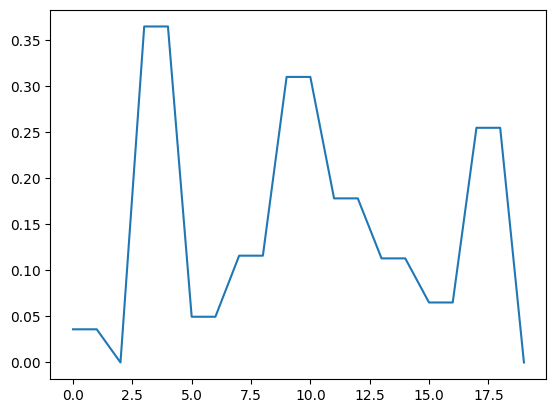

inf


/state/partition1/job-44925268/ipykernel_894445/3220589088.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  print(2* np.pi/np.abs(np.angle(Lam_uy_sort[2])))


In [13]:
beg_os_t = 800
end_os_t = 1000
beg_height = 0
print(avg_uy_all_time.shape)
sample_data_uy = avg_uy_all_time[beg_height:,beg_os_t:end_os_t]
phi_uy, Lam_uy, b_uy = DMD(sample_data_uy)
#print(phi_KE[0])
print(Lam_uy)
#print(b_KE[0])


dt = 1
timesteps = 500
future_uy = compute_future_states(phi_uy, Lam_uy, b_uy, timesteps, 1)
#future_nD = compute_future_states(phi_nD, Lam_nD, b_nD, timesteps, 1)

dummy = np.arange(0,2 *np.pi,0.01)

plt.scatter(np.real(Lam_uy),np.imag(Lam_uy),color = 'r')

plt.plot(np.cos(dummy),np.sin(dummy))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

Lam_uy_sort = Lam_uy[np.argsort(-np.abs(Lam_uy))]
plt.plot(np.abs(Lam_uy_sort[:20]))
plt.show()
plt.plot(np.abs(np.angle(Lam_uy_sort[:20])))
plt.show()
print(2* np.pi/np.abs(np.angle(Lam_uy_sort[2])))

(64, 2500)
[ 9.47133662e-01+2.83008207e-01j  9.47133662e-01-2.83008207e-01j
  9.62661016e-01+2.44715676e-01j  9.62661016e-01-2.44715676e-01j
  9.66676402e-01+1.40082179e-01j  9.66676402e-01-1.40082179e-01j
  9.71544056e-01+1.01338259e-01j  9.71544056e-01-1.01338259e-01j
  9.32683214e-01+5.32142261e-02j  9.32683214e-01-5.32142261e-02j
  9.96254793e-01+5.17716825e-02j  9.96254793e-01-5.17716825e-02j
  9.93438493e-01+4.81911864e-02j  9.93438493e-01-4.81911864e-02j
  9.87185497e-01+4.56646038e-02j  9.87185497e-01-4.56646038e-02j
  9.95601338e-01+1.65852555e-04j  9.95601338e-01-1.65852555e-04j
  3.86761322e-01+1.92226689e-01j  3.86761322e-01-1.92226689e-01j
 -1.79431118e-01+0.00000000e+00j  1.43331035e-01+0.00000000e+00j
 -1.18842641e-01+0.00000000e+00j  8.03801323e-02+1.47667829e-02j
  8.03801323e-02-1.47667829e-02j -2.25503844e-02+8.17431822e-02j
 -2.25503844e-02-8.17431822e-02j -8.14933608e-02+0.00000000e+00j
  2.20416813e-03+7.21956808e-02j  2.20416813e-03-7.21956808e-02j
  5.72024271e-

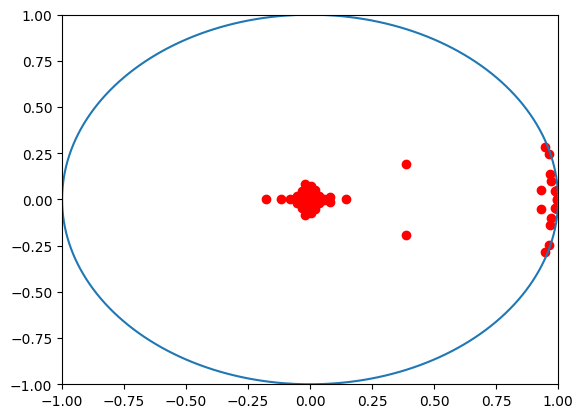

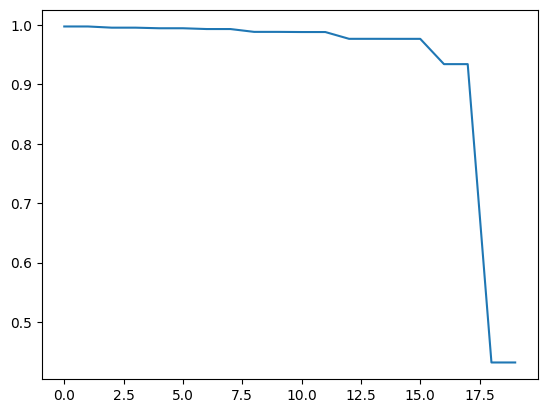

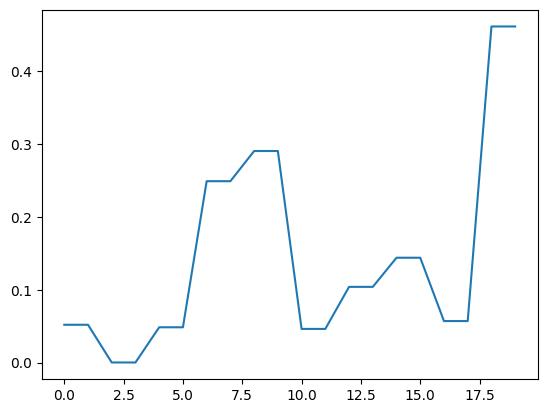

37717.5241964074


In [18]:
beg_os_t = 1150
end_os_t = 1600
beg_height = 0
print(avg_uy_all_time.shape)
sample_data_uy = avg_uy_all_time[beg_height:,beg_os_t:end_os_t]
phi_uy, Lam_uy, b_uy = DMD(sample_data_uy)
#print(phi_KE[0])
print(Lam_uy)
#print(b_KE[0])


dt = 1
timesteps = 500
future_uy = compute_future_states(phi_uy, Lam_uy, b_uy, timesteps, 1)
#future_nD = compute_future_states(phi_nD, Lam_nD, b_nD, timesteps, 1)

dummy = np.arange(0,2 *np.pi,0.01)

plt.scatter(np.real(Lam_uy),np.imag(Lam_uy),color = 'r')

plt.plot(np.cos(dummy),np.sin(dummy))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

Lam_uy_sort = Lam_uy[np.argsort(-np.abs(Lam_uy))]
plt.plot(np.abs(Lam_uy_sort[:20]))
plt.show()
plt.plot(np.abs(np.angle(Lam_uy_sort[:20])))
plt.show()
print(2* np.pi/np.abs(np.angle(Lam_uy_sort[2])))

(64, 2500)
[ 0.86158569+0.28007738j  0.86158569-0.28007738j  0.96005951+0.24080437j
  0.96005951-0.24080437j  0.97623722+0.17512688j  0.97623722-0.17512688j
  0.98290633+0.11667267j  0.98290633-0.11667267j  0.99497397+0.0599999j
  0.99497397-0.0599999j   0.9993472 +0.0500699j   0.9993472 -0.0500699j
  0.99647365+0.04728862j  0.99647365-0.04728862j  0.99675586+0.j
  0.65411268+0.04984951j  0.65411268-0.04984951j -0.24949835+0.10454452j
 -0.24949835-0.10454452j  0.0125397 +0.2348237j   0.0125397 -0.2348237j
 -0.159569  +0.j          0.14428491+0.j          0.03115383+0.14686616j
  0.03115383-0.14686616j  0.07105235+0.11150376j  0.07105235-0.11150376j
 -0.02325489+0.10761927j -0.02325489-0.10761927j -0.0795266 +0.07037475j
 -0.0795266 -0.07037475j -0.05452535+0.08458677j -0.05452535-0.08458677j
 -0.01743592+0.09178665j -0.01743592-0.09178665j  0.08361914+0.j
  0.06435913+0.0469133j   0.06435913-0.0469133j   0.03369391+0.06978132j
  0.03369391-0.06978132j -0.08855928+0.02600382j -0.0885592

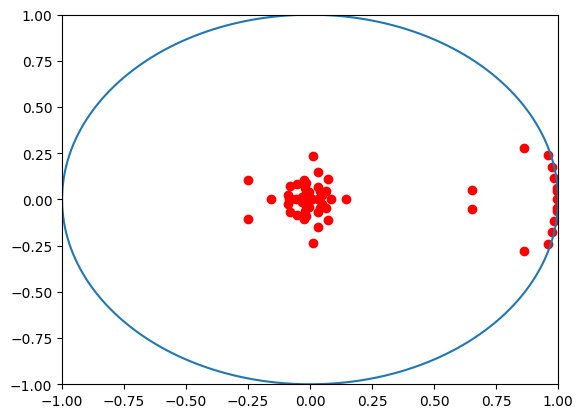

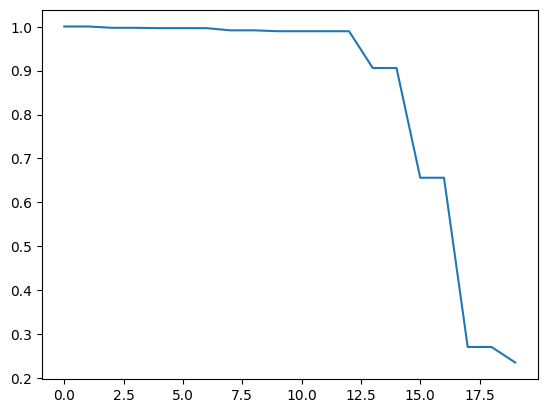

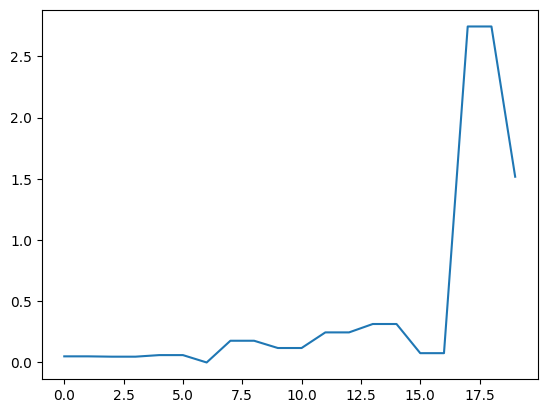

132.49966241771014


In [19]:
beg_os_t = 1450
end_os_t = 1600
beg_height = 0
print(avg_uy_all_time.shape)
sample_data_uy = avg_uy_all_time[beg_height:,beg_os_t:end_os_t]
phi_uy, Lam_uy, b_uy = DMD(sample_data_uy)
#print(phi_KE[0])
print(Lam_uy)
#print(b_KE[0])


dt = 1
timesteps = 500
future_uy = compute_future_states(phi_uy, Lam_uy, b_uy, timesteps, 1)
#future_nD = compute_future_states(phi_nD, Lam_nD, b_nD, timesteps, 1)

dummy = np.arange(0,2 *np.pi,0.01)

plt.scatter(np.real(Lam_uy),np.imag(Lam_uy),color = 'r')

plt.plot(np.cos(dummy),np.sin(dummy))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

Lam_uy_sort = Lam_uy[np.argsort(-np.abs(Lam_uy))]
plt.plot(np.abs(Lam_uy_sort[:20]))
plt.show()
plt.plot(np.abs(np.angle(Lam_uy_sort[:20])))
plt.show()
print(2* np.pi/np.abs(np.angle(Lam_uy_sort[2])))

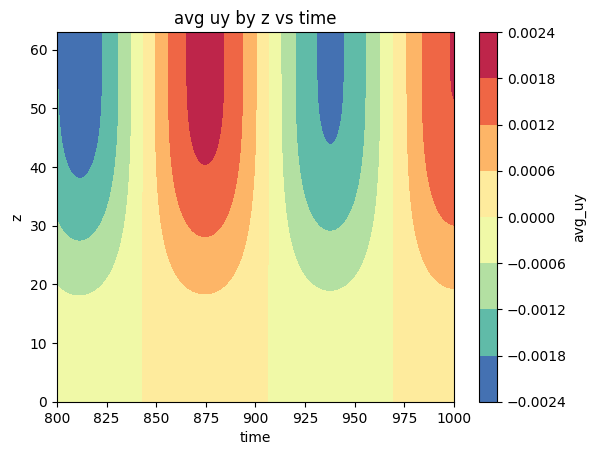

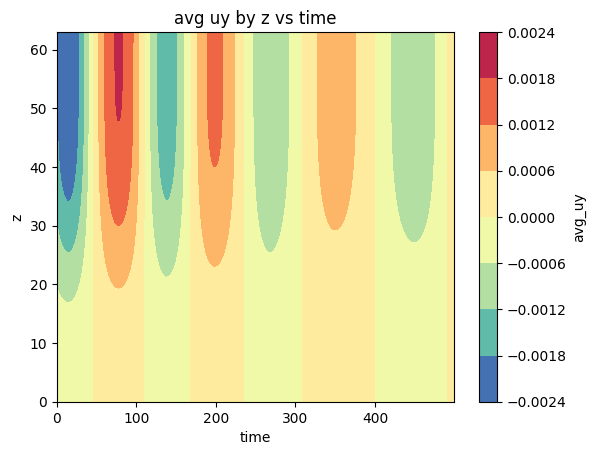

In [16]:
avg_uy_loc_T=avg_uy_all_time[:, beg_os_t:end_os_t] # This is where we want to show from the sample data

#avg_nD_loc_T=np.transpose(avg_nD_all_time[beg_os_t:end_os_t,:])

n_rows, n_columns = avg_uy_loc_T.shape
x_ax = np.linspace(beg_os_t, end_os_t, n_columns)
y_ax = np.linspace(0, n_rows-1, n_rows)
X_ax, Y_ax = np.meshgrid(x_ax, y_ax)

# uyuyuyuyuyuyuyuyuyuyuyuyuyuy
plt.contourf(X_ax, Y_ax, avg_uy_loc_T, cmap='Spectral_r')
plt.colorbar(label='avg_uy')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg uy by z vs time')
# plt.savefig(f'avg_uy_local.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()

plt.contourf(future_uy, cmap='Spectral_r')
plt.colorbar(label='avg_uy')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg uy by z vs time')
# plt.savefig(f'predict_avg_uy_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()


In [17]:
# The following are saved for debugging purpose
"""
recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        st = file['scales/sim_time']
        simtime = np.array(st)
        avg_KE_0 = file["tasks"]["avg KE by z"]
        avg_KE = np.reshape(avg_KE_0, (len(simtime),Nz))
        for t in range(len(simtime)):
            avg_KE_T=np.transpose(avg_KE[t,:])
            avg_KE_T = np.reshape(avg_KE_T, (1, Nz))
            if recorded == False:
                avg_KE_all_time = avg_KE_T
                recorded = True
            else:
                avg_KE_all_time = np.concatenate((avg_KE_all_time, avg_KE_T))
print(np.shape(avg_KE_all_time))
print(np.shape(np.transpose(avg_KE_all_time[:,:])))
avg_KE_allt_T=np.transpose(avg_KE_all_time[:,:])
plt.contourf(avg_KE_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_KE')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg KE by z vs time')
plt.savefig(f'avg_KE_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()"""
"""
recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        avg_M_0 = file["tasks"]["avg M by z"]
        avg_M = np.reshape(avg_M_0, (len(simtime), Nz)) # which is (1000, 32)
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(len(simtime)):
            avg_M_T=np.transpose(avg_M[t,:])
            avg_M_T = np.reshape(avg_M_T, (1, Nz))
            if recorded == False:
                avg_M_all_time = avg_M_T
                recorded = True
            else:
                avg_M_all_time = np.concatenate((avg_M_all_time, avg_M_T))
print(np.shape(avg_M_all_time))
print(np.shape(np.transpose(avg_M_all_time[:,:])))
avg_M_allt_T=np.transpose(avg_M_all_time[:,:])
plt.contourf(avg_M_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_M')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg_M_by_z_vs_time')
plt.savefig(f'avg_M_t.png', dpi=200,bbox_inches='tight')
plt.show()

matplotlib.pyplot.close()
"""
"""recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        avg_nD_0 = file["tasks"]["avg -D by z"]
        avg_nD = np.reshape(avg_nD_0, (len(simtime), Nz)) # which is (1000, 32)
        st = file['scales/sim_time']
        simtime = np.array(st)
        for t in range(len(simtime)):
            avg_nD_T=np.transpose(avg_nD[t,:])
            avg_nD_T = np.reshape(avg_nD_T, (1, Nz))
            if recorded == False:
                avg_nD_all_time = avg_nD_T
                recorded = True
            else:
                avg_nD_all_time = np.concatenate((avg_nD_all_time, avg_nD_T))
print(np.shape(avg_nD_all_time))
print(np.shape(np.transpose(avg_nD_all_time[:,:])))
avg_nD_allt_T=np.transpose(avg_nD_all_time[:,:])
plt.contourf(avg_nD_allt_T, cmap='Spectral_r')
plt.colorbar(label='avg_nD')
plt.xlabel('time')
plt.ylabel('z')
plt.title('avg -D by z vs time')
plt.savefig(f'avg_nD_t.png', dpi=200,bbox_inches='tight')
plt.show()
matplotlib.pyplot.close()"""

'recorded = False\nfor file in file_paths:\n    with h5py.File(file, mode=\'r\') as file:\n        avg_nD_0 = file["tasks"]["avg -D by z"]\n        avg_nD = np.reshape(avg_nD_0, (len(simtime), Nz)) # which is (1000, 32)\n        st = file[\'scales/sim_time\']\n        simtime = np.array(st)\n        for t in range(len(simtime)):\n            avg_nD_T=np.transpose(avg_nD[t,:])\n            avg_nD_T = np.reshape(avg_nD_T, (1, Nz))\n            if recorded == False:\n                avg_nD_all_time = avg_nD_T\n                recorded = True\n            else:\n                avg_nD_all_time = np.concatenate((avg_nD_all_time, avg_nD_T))\nprint(np.shape(avg_nD_all_time))\nprint(np.shape(np.transpose(avg_nD_all_time[:,:])))\navg_nD_allt_T=np.transpose(avg_nD_all_time[:,:])\nplt.contourf(avg_nD_allt_T, cmap=\'Spectral_r\')\nplt.colorbar(label=\'avg_nD\')\nplt.xlabel(\'time\')\nplt.ylabel(\'z\')\nplt.title(\'avg -D by z vs time\')\nplt.savefig(f\'avg_nD_t.png\', dpi=200,bbox_inches=\'tight\'